In [4]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import dlib
from mtcnn.mtcnn import MTCNN
import pydot_ng as pydot
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Tensorflow version %s" % tf.__version__)


Tensorflow version 2.2.0


In [5]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Training Part

In [6]:
# Load data...
data_dir = '/home/leon/jupyter_workspace/CS765/TermProject/train/train_image/'
train_dir = os.path.join(data_dir, "Train")
val_dir = os.path.join(data_dir, 'Validation')
test_dir = os.path.join(data_dir, 'Test')

In [7]:
# Define ImageDataGenerator...
batch_size = 64
IMG_SIZE = 120 

# create data generators
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

train_iter = train_datagen.flow_from_directory(
    directory = train_dir,
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = 97,
    target_size = (IMG_SIZE, IMG_SIZE)
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

val_iter = test_datagen.flow_from_directory(
    directory = val_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    seed = 41,
    target_size=(IMG_SIZE, IMG_SIZE)
)

test_iter = test_datagen.flow_from_directory(
    directory = test_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    seed = 41,
    target_size=(IMG_SIZE, IMG_SIZE)
)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [8]:
print(next(iter(train_iter))[0].shape) # train_iter shape (64, 120, 120, 3)
print(next(iter(train_iter))[1].shape) # train_iter label shape (64, 2)


(64, 120, 120, 3)
(64, 2)


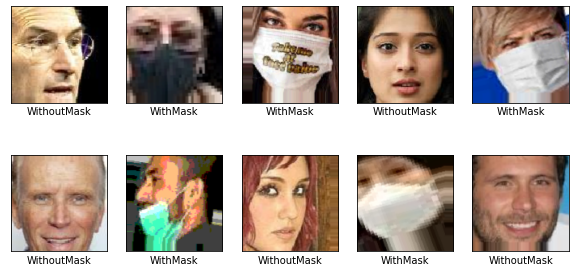

In [6]:
# show training images and labels...
train_imgs, train_labels = next(iter(train_iter))
class_names = ['WithMask', 'WithoutMask']


plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_imgs[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[int(train_labels[i][1])])

plt.show()

In [42]:
# Model building...
base_model = keras.applications.VGG19(include_top=False,input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

VGG_model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2,activation='sigmoid')
])


In [44]:
VGG_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 20,614,594
Trainable params: 590,210
Non-trainable params: 20,024,384
_________________________________________________________________


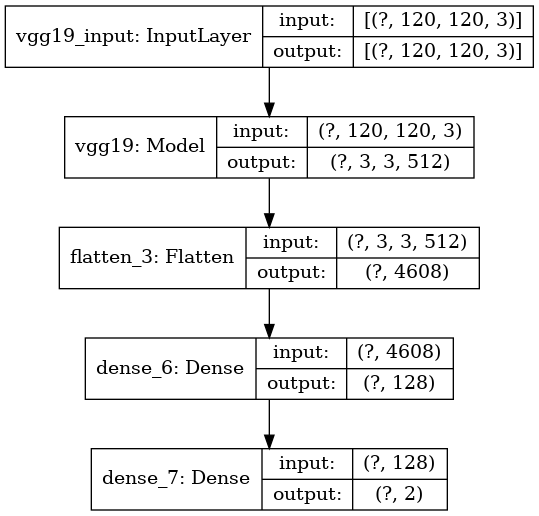

In [45]:
# Show model...
keras.utils.plot_model(VGG_model, show_shapes=True)

In [46]:
VGG_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [53]:
# Setting for model training...
EPOCHS = 15

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=2, 
    verbose=1
    )

# Reducing the learning rate by half when val_loss is not decreasing...
lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_categorical_accuracy',
    factor=0.5,
    patience=2,
    verbose=1
    )

In [48]:
history = VGG_model.fit(
    train_iter,
    validation_data=val_iter, 
    epochs=EPOCHS, 
    callbacks=[early_stop,lr_reduction]
    )

Epoch 1/15
157/157 [==============================] - 42s 267ms/step - loss: 0.1404 - categorical_accuracy: 0.9515 - val_loss: 0.0152 - val_categorical_accuracy: 0.9962 - lr: 0.0010
Epoch 2/15
157/157 [==============================] - 42s 268ms/step - loss: 0.0487 - categorical_accuracy: 0.9822 - val_loss: 0.0978 - val_categorical_accuracy: 0.9588 - lr: 0.0010
Epoch 3/15
157/157 [==============================] - 42s 266ms/step - loss: 0.0384 - categorical_accuracy: 0.9866 - val_loss: 0.0129 - val_categorical_accuracy: 0.9975 - lr: 0.0010
Epoch 4/15
157/157 [==============================] - 42s 269ms/step - loss: 0.0322 - categorical_accuracy: 0.9880 - val_loss: 0.0094 - val_categorical_accuracy: 0.9962 - lr: 0.0010
Epoch 5/15
157/157 [==============================] - ETA: 0s - loss: 0.0281 - categorical_accuracy: 0.9890
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
157/157 [==============================] - 42s 269ms/step - loss: 0.0281 - categoric

In [59]:
# Evaluation...
VGG_model.evaluate(test_iter, verbose=1)


16/16 [==============================] - 3s 184ms/step - loss: 0.0165 - categorical_accuracy: 0.9960


[0.016535306349396706, 0.9959677457809448]

In [9]:
# Metrix evaluation...
predictions = VGG_model.predict(test_iter)
y_pred = np.argmax(predictions, axis=-1)
test_labels=test_iter.classes 

print(classification_report(test_labels,y_pred))
print(confusion_matrix(test_labels, y_pred))
print(accuracy_score(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       1.00      0.99      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992

[[482   1]
 [  3 506]]
0.9959677419354839


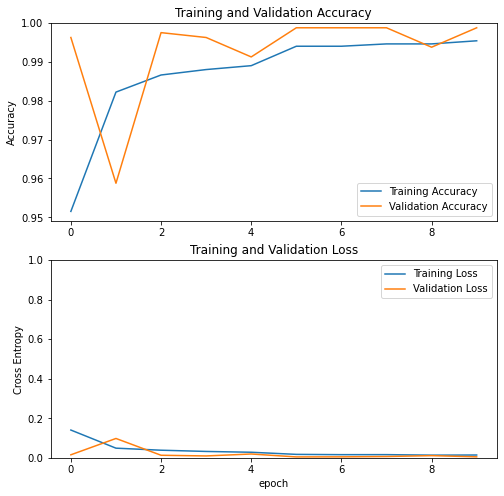

In [64]:
# Visualization evaluation...
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
# save model...
VGG_model.save('VGG19_FaceMaskDetection.h5')

# Prediction part

In [55]:
# Setting Test result...
Result_dir = '/home/leon/jupyter_workspace/CS765/TermProject/test/test_images/'
model = keras.models.load_model('VGG19_FaceMaskDetection.h5')

mask_label = {0: 'WithMask', 1: 'WithoutMask'}
rect_label = {0: (0, 255, 0), 1: (255, 0, 0)} # rectangle color

<function matplotlib.pyplot.show(close=None, block=None)>

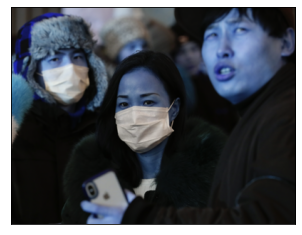

In [160]:
# Load test image...
img = cv2.imread(os.path.join(Result_dir, "maksssksksss83.png"))
img2 = cv2.imread(os.path.join(Result_dir, "maksssksksss29.png"))
img3 = cv2.imread(os.path.join(Result_dir, "maksssksksss209.png"))

plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

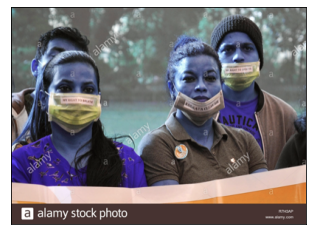

In [109]:
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

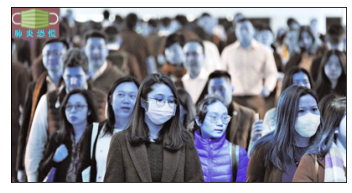

In [161]:
plt.imshow(img3)
plt.xticks([])
plt.yticks([])
plt.show

## Using Dlib for face detection

rectangles[[(247, 8) (354, 116)], [(137, 113) (212, 188)]]


<function matplotlib.pyplot.show(close=None, block=None)>

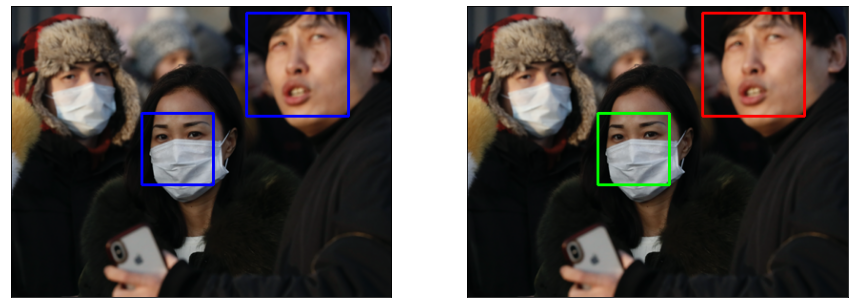

In [187]:
# Using Dlib HOG based frontal face detector to make a human face detection...
face_model_Dlib = dlib.get_frontal_face_detector()

# Produce gray image and output image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Returns [(x,y) (x1, y1)] 
faces_Dlib = face_model_Dlib(gray_img, 1)
print(faces_Dlib)

for result in faces_Dlib:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    cv2.rectangle(out_img, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Dlib:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img.shape[1]): x1 = img.shape[1]
    if(y1 > img.shape[0]): y1 = img.shape[0]
    crop = out_img[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show

rectangles[[(225, 80) (287, 142)]]


<function matplotlib.pyplot.show(close=None, block=None)>

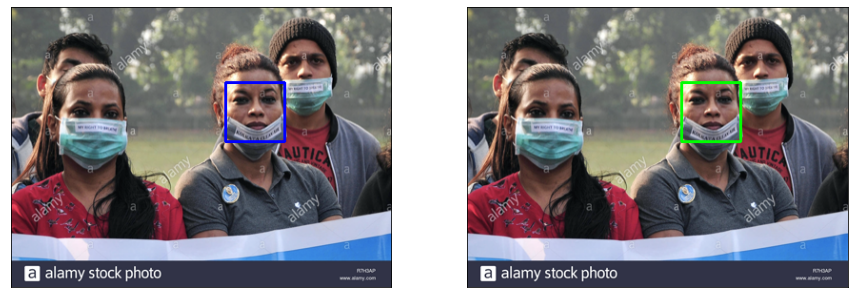

In [188]:
# Produce gray image and output image
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
out_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

# Returns [(x,y) (x1, y1)] 
faces_Dlib2 = face_model_Dlib(gray_img2, 1)
print(faces_Dlib2)

for result in faces_Dlib2:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    cv2.rectangle(out_img2, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Dlib2:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img2.shape[1]): x1 = img2.shape[1]
    if(y1 > img2.shape[0]): y1 = img2.shape[0]
    crop = out_img2[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img2, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show


rectangles[[(229, 122) (265, 158)], [(117, 94) (153, 130)], [(337, 118) (373, 154)], [(160, 94) (204, 137)], [(57, 106) (93, 142)]]


<function matplotlib.pyplot.show(close=None, block=None)>

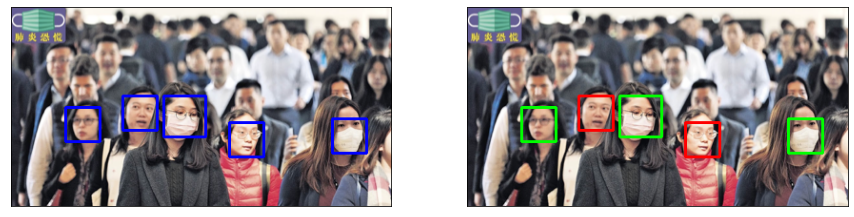

In [189]:
# Produce gray image and output image
gray_img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)
out_img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)

# Returns [(x,y) (x1, y1)] 
faces_Dlib3 = face_model_Dlib3(gray_img3, 1)
print(faces_Dlib3)

for result in faces_Dlib3:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    cv2.rectangle(out_img3, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Dlib3:
    x = result.left()
    y = result.top()
    x1 = result.right()
    y1 = result.bottom()
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img3.shape[1]): x1 = img3.shape[1]
    if(y1 > img3.shape[0]): y1 = img3.shape[0]
    crop = out_img3[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img3, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show


## Using Haar for face detection

[[260  10  82  82]
 [126  96 106 106]]


<function matplotlib.pyplot.show(close=None, block=None)>

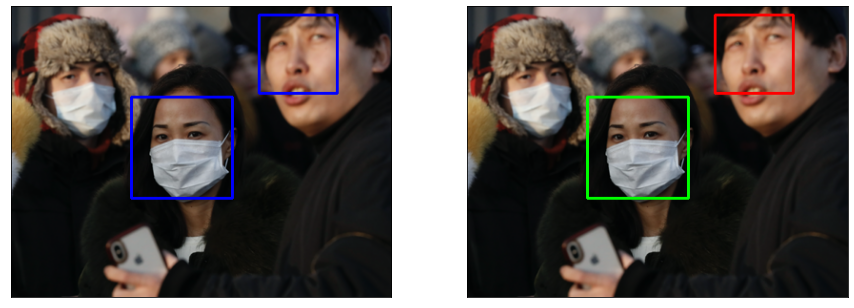

In [190]:
# Using haar cascade to make a human face detection...
face_model_Haar = cv2.CascadeClassifier('/home/leon/jupyter_workspace/CS765/TermProject/haarcascades/haarcascade_frontalface_default.xml')

# Produce gray image and output image
gray_img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Returns (x,y,w,h)
faces_Haar = face_model_Haar.detectMultiScale(gray_img)
print(faces_Haar)

for result in faces_Haar:
    x, y, w, h = result
    x1, y1 = x + w, y + h
    cv2.rectangle(out_img, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Haar:
    x, y, w, h = result
    x1, y1 = x + w, y + h
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img.shape[1]): x1 = img.shape[1]
    if(y1 > img.shape[0]): y1 = img.shape[0]
    crop = out_img[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show

[[131  60  24  24]
 [221  69  73  73]
 [277  33  63  63]
 [ 44  78  90  90]]


<function matplotlib.pyplot.show(close=None, block=None)>

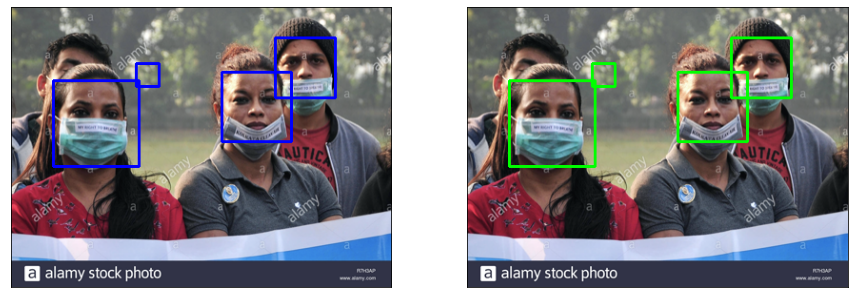

In [191]:
# Produce gray image and output image
gray_img2 = cv2.cvtColor(img2, cv2.IMREAD_GRAYSCALE)
out_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

# Returns (x,y,w,h)
faces_Haar2 = face_model_Haar.detectMultiScale(gray_img2)
print(faces_Haar2)

for result in faces_Haar2:
    x, y, w, h = result
    x1, y1 = x + w, y + h
    cv2.rectangle(out_img2, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Haar2:
    x, y, w, h = result
    x1, y1 = x + w, y + h
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img2.shape[1]): x1 = img2.shape[1]
    if(y1 > img2.shape[0]): y1 = img2.shape[0]
    crop = out_img2[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img2, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show

[[ 59 107  35  35]
 [372  62  26  26]
 [117  91  39  39]
 [228 117  39  39]
 [201  44  34  34]
 [334 109  42  42]
 [158  93  48  48]]


<function matplotlib.pyplot.show(close=None, block=None)>

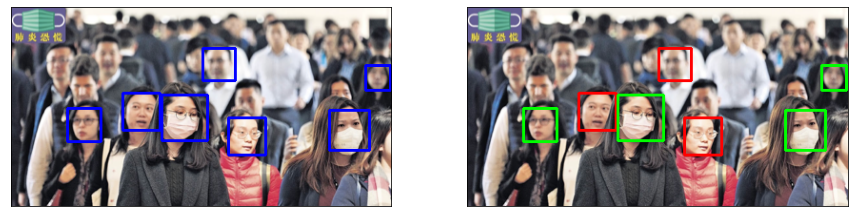

In [192]:
# Produce gray image and output image
gray_img3 = cv2.cvtColor(img3, cv2.IMREAD_GRAYSCALE)
out_img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)

# Returns (x,y,w,h)
faces_Haar3 = face_model_Haar.detectMultiScale(gray_img3)
print(faces_Haar3)

for result in faces_Haar3:
    x, y, w, h = result
    x1, y1 = x + w, y + h
    cv2.rectangle(out_img3, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Haar3:
    x, y, w, h = result
    x1, y1 = x + w, y + h
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img3.shape[1]): x1 = img3.shape[1]
    if(y1 > img3.shape[0]): y1 = img3.shape[0]
    crop = out_img3[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img3, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show


## Using MTCNN for face detection

In [205]:
# Using MTCNN to make a human face detection...
face_model_Mtcnn = MTCNN()

[{'box': [144, 96, 80, 105], 'confidence': 0.9999626874923706, 'keypoints': {'left_eye': (158, 139), 'right_eye': (194, 137), 'nose': (169, 159), 'mouth_left': (158, 176), 'mouth_right': (192, 173)}}, {'box': [264, -1, 98, 126], 'confidence': 0.9998937845230103, 'keypoints': {'left_eye': (281, 41), 'right_eye': (323, 35), 'nose': (293, 64), 'mouth_left': (287, 95), 'mouth_right': (316, 90)}}, {'box': [231, 48, 33, 40], 'confidence': 0.9470317959785461, 'keypoints': {'left_eye': (242, 63), 'right_eye': (258, 61), 'nose': (251, 71), 'mouth_left': (248, 80), 'mouth_right': (259, 79)}}, {'box': [34, 37, 72, 88], 'confidence': 0.9184998869895935, 'keypoints': {'left_eye': (58, 75), 'right_eye': (92, 70), 'nose': (78, 97), 'mouth_left': (64, 110), 'mouth_right': (91, 106)}}, {'box': [150, 57, 33, 40], 'confidence': 0.9129189848899841, 'keypoints': {'left_eye': (162, 73), 'right_eye': (173, 69), 'nose': (170, 79), 'mouth_left': (164, 87), 'mouth_right': (175, 84)}}]


<function matplotlib.pyplot.show(close=None, block=None)>

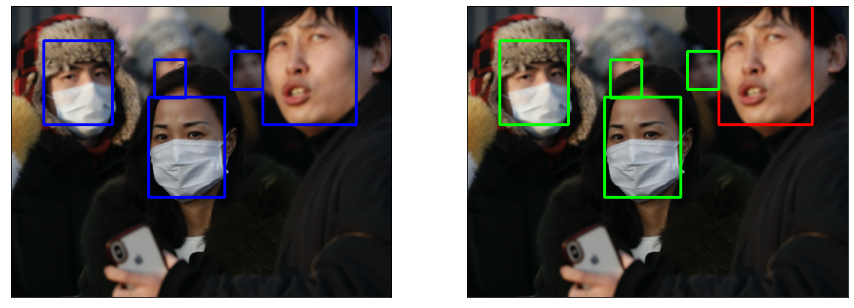

In [207]:
# Produce output image
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Returns (x,y,w,h)
faces_Mtcnn = face_model_Mtcnn.detect_faces(out_img)
print(faces_Mtcnn)

for result in faces_Mtcnn:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    cv2.rectangle(out_img, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Mtcnn:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img.shape[1]): x1 = img.shape[1]
    if(y1 > img.shape[0]): y1 = img.shape[0]
    crop = out_img[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show


[{'box': [282, 37, 53, 62], 'confidence': 0.9999988079071045, 'keypoints': {'left_eye': (295, 60), 'right_eye': (320, 57), 'nose': (308, 69), 'mouth_left': (298, 85), 'mouth_right': (321, 82)}}, {'box': [52, 76, 68, 86], 'confidence': 0.999932050704956, 'keypoints': {'left_eye': (74, 110), 'right_eye': (106, 110), 'nose': (91, 127), 'mouth_left': (76, 141), 'mouth_right': (101, 143)}}, {'box': [224, 67, 57, 74], 'confidence': 0.9998337030410767, 'keypoints': {'left_eye': (242, 99), 'right_eye': (270, 97), 'nose': (257, 110), 'mouth_left': (244, 125), 'mouth_right': (269, 124)}}]


<function matplotlib.pyplot.show(close=None, block=None)>

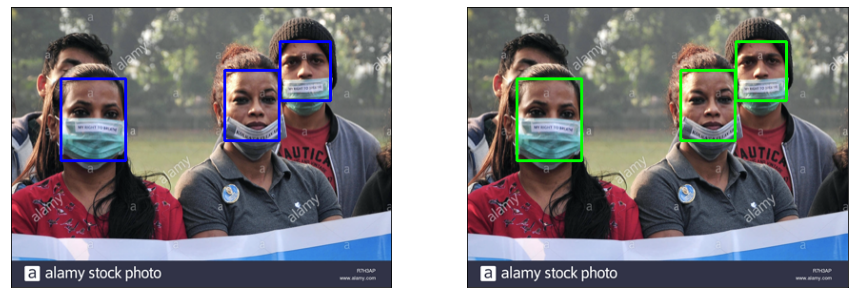

In [195]:
# Produce output image
out_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

# Returns (x,y,w,h)
faces_Mtcnn2 = face_model_Mtcnn.detect_faces(out_img2)
print(faces_Mtcnn2)

for result in faces_Mtcnn2:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    cv2.rectangle(out_img2, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Mtcnn2:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img2.shape[1]): x1 = img2.shape[1]
    if(y1 > img2.shape[0]): y1 = img2.shape[0]
    crop = out_img2[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img2, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show

[{'box': [121, 92, 28, 39], 'confidence': 0.9999748468399048, 'keypoints': {'left_eye': (131, 106), 'right_eye': (144, 107), 'nose': (138, 114), 'mouth_left': (131, 122), 'mouth_right': (141, 123)}}, {'box': [65, 106, 24, 33], 'confidence': 0.9999710321426392, 'keypoints': {'left_eye': (70, 119), 'right_eye': (81, 119), 'nose': (73, 126), 'mouth_left': (71, 133), 'mouth_right': (79, 133)}}, {'box': [230, 117, 28, 40], 'confidence': 0.9996899366378784, 'keypoints': {'left_eye': (242, 132), 'right_eye': (255, 133), 'nose': (251, 141), 'mouth_left': (243, 148), 'mouth_right': (253, 149)}}, {'box': [205, 44, 22, 32], 'confidence': 0.9996730089187622, 'keypoints': {'left_eye': (210, 57), 'right_eye': (221, 56), 'nose': (214, 64), 'mouth_left': (211, 69), 'mouth_right': (221, 68)}}, {'box': [162, 94, 34, 45], 'confidence': 0.9988433122634888, 'keypoints': {'left_eye': (177, 111), 'right_eye': (191, 114), 'nose': (185, 123), 'mouth_left': (172, 126), 'mouth_right': (186, 129)}}, {'box': [90, 

<function matplotlib.pyplot.show(close=None, block=None)>

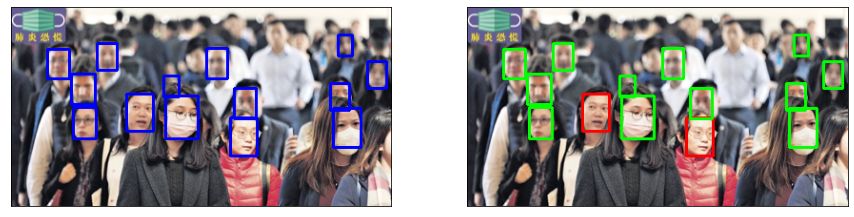

In [197]:
# Produce output image
out_img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)

# Returns (x,y,w,h)
faces_Mtcnn3 = face_model_Mtcnn.detect_faces(out_img3)
print(faces_Mtcnn3)

for result in faces_Mtcnn3:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    cv2.rectangle(out_img3, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for result in faces_Mtcnn3:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    if(x < 0): x = 0
    if(y < 0): y = 0
    if(x1 > img3.shape[1]): x1 = img3.shape[1]
    if(y1 > img3.shape[0]): y1 = img3.shape[0]
    crop = out_img3[y:y1, x:x1]
    crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
    mask_result = model.predict(crop).argmax()
    cv2.rectangle(out_img3, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show

## Using DNN Face Detector in OpenCV for face detection

(1, 1, 200, 7)


<function matplotlib.pyplot.show(close=None, block=None)>

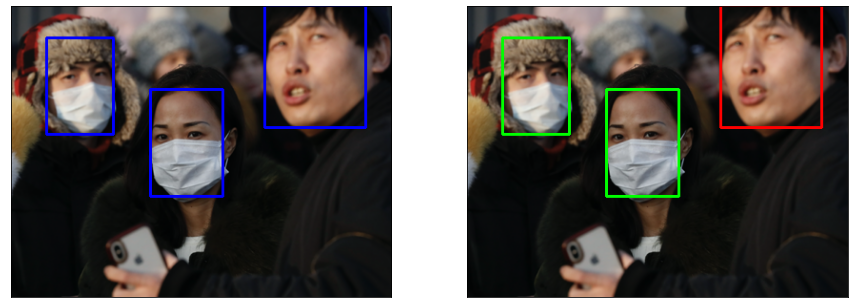

In [198]:
# Setting model config...
modelFile = "/home/leon/jupyter_workspace/CS765/TermProject/CAFFE_DNN/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "/home/leon/jupyter_workspace/CS765/TermProject/CAFFE_DNN/deploy.prototxt.txt"
face_model_Dnn = cv2.dnn.readNetFromCaffe(configFile, modelFile)
h, w = img.shape[:2]

# Produce output image
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# To achieve the best accuracy run the model on BGR images
blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))

# Using DNN Face Detector in OpenCV to make a human face detection...
face_model_Dnn.setInput(blob)
faces_Dnn = face_model_Dnn.forward()
print(faces_Dnn.shape)

for i in range(faces_Dnn.shape[2]):
        confidence = faces_Dnn[0, 0, i, 2]
        if confidence > 0.5:
            box = faces_Dnn[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            cv2.rectangle(out_img, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for i in range(faces_Dnn.shape[2]):
        confidence = faces_Dnn[0, 0, i, 2]
        if confidence > 0.5:
            box = faces_Dnn[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            if(x < 0): x = 0
            if(y < 0): y = 0
            if(x1 > img.shape[1]): x1 = img.shape[1]
            if(y1 > img.shape[0]): y1 = img.shape[0]
            crop = out_img[y:y1, x:x1]
            crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
            crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
            mask_result = model.predict(crop).argmax()
            cv2.rectangle(out_img, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img)
plt.xticks([])
plt.yticks([])
plt.show


(1, 1, 200, 7)


<function matplotlib.pyplot.show(close=None, block=None)>

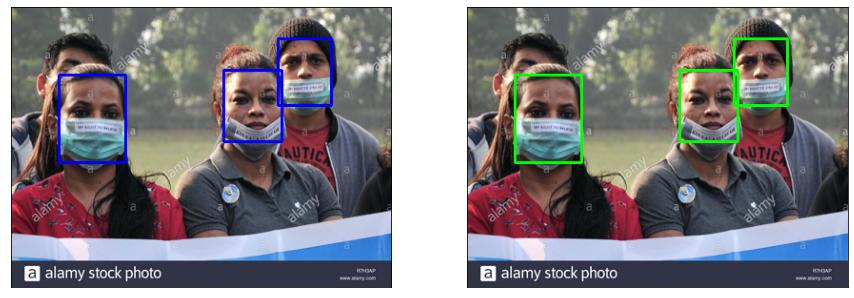

In [199]:
h2, w2 = img2.shape[:2]

# Produce output image
out_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

# To achieve the best accuracy run the model on BGR images
blob2 = cv2.dnn.blobFromImage(cv2.resize(img2, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))

# Using DNN Face Detector in OpenCV to make a human face detection...
face_model_Dnn.setInput(blob2)
faces_Dnn2 = face_model_Dnn.forward()
print(faces_Dnn2.shape)

for i in range(faces_Dnn2.shape[2]):
        confidence = faces_Dnn2[0, 0, i, 2]
        if confidence > 0.5:
            box = faces_Dnn2[0, 0, i, 3:7] * np.array([w2, h2, w2, h2])
            (x, y, x1, y1) = box.astype("int")
            cv2.rectangle(out_img2, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for i in range(faces_Dnn2.shape[2]):
        confidence = faces_Dnn2[0, 0, i, 2]
        if confidence > 0.5:
            box = faces_Dnn2[0, 0, i, 3:7] * np.array([w2, h2, w2, h2])
            (x, y, x1, y1) = box.astype("int")
            if(x < 0): x = 0
            if(y < 0): y = 0
            if(x1 > img2.shape[1]): x1 = img2.shape[1]
            if(y1 > img2.shape[0]): y1 = img2.shape[0]
            crop = out_img2[y:y1, x:x1]
            crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
            crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
            mask_result = model.predict(crop).argmax()
            cv2.rectangle(out_img2, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img2)
plt.xticks([])
plt.yticks([])
plt.show


(1, 1, 200, 7)


<function matplotlib.pyplot.show(close=None, block=None)>

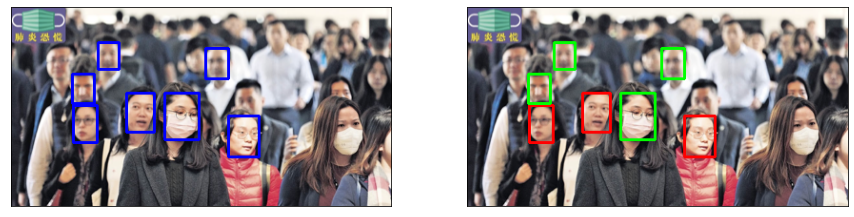

In [200]:
h3, w3 = img3.shape[:2]

# Produce output image
out_img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)

# To achieve the best accuracy run the model on BGR images
blob3 = cv2.dnn.blobFromImage(cv2.resize(img3, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))

# Using DNN Face Detector in OpenCV to make a human face detection...
face_model_Dnn.setInput(blob3)
faces_Dnn3 = face_model_Dnn.forward()
print(faces_Dnn.shape)

for i in range(faces_Dnn3.shape[2]):
        confidence = faces_Dnn3[0, 0, i, 2]
        if confidence > 0.5:
            box = faces_Dnn3[0, 0, i, 3:7] * np.array([w3, h3, w3, h3])
            (x, y, x1, y1) = box.astype("int")
            cv2.rectangle(out_img3, (x, y), (x1, y1), (0, 0, 255), 2)

plt.figure(figsize=[15, 10])
plt.subplot(1, 2, 1)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show

# Adding prediction labels...
for i in range(faces_Dnn3.shape[2]):
        confidence = faces_Dnn3[0, 0, i, 2]
        if confidence > 0.5:
            box = faces_Dnn3[0, 0, i, 3:7] * np.array([w3, h3, w3, h3])
            (x, y, x1, y1) = box.astype("int")
            if(x < 0): x = 0
            if(y < 0): y = 0
            if(x1 > img3.shape[1]): x1 = img3.shape[1]
            if(y1 > img3.shape[0]): y1 = img3.shape[0]
            crop = out_img3[y:y1, x:x1]
            crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
            crop = np.reshape(crop,[1, IMG_SIZE, IMG_SIZE, 3]) / 255.0
            mask_result = model.predict(crop).argmax()
            cv2.rectangle(out_img3, (x, y), (x1, y1), rect_label[mask_result], 2)

plt.subplot(1, 2, 2)
plt.imshow(out_img3)
plt.xticks([])
plt.yticks([])
plt.show
